In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
import os
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dataset\database.sqlite
./dataset\hashes.txt
./dataset\Reviews.csv


In [3]:
#载入数据
df = pd.read_csv('./dataset/Reviews.csv')

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
#去除非必要项
df = df.drop(['Id', 'ProfileName','Time','HelpfulnessNumerator','HelpfulnessDenominator','Text','Summary'], axis = 1) 

In [7]:
df.shape

(568454, 3)

In [8]:
df[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


In [10]:
#确定评价的最大最小值
def find_min_max_rating():
    print('The minimum rating is: %d' %(df['Score'].min()))
    print('The maximum rating is: %d' %(df['Score'].max()))
    
find_min_max_rating() 

The minimum rating is: 1
The maximum rating is: 5


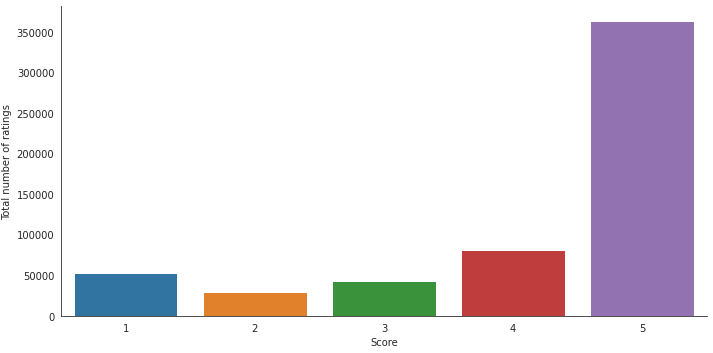

In [11]:
#确定分布
with sns.axes_style('white'):
    g = sns.factorplot("Score", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [12]:
#判断前十的UserID评价
most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
A1TMAVN4CEM8U8    204
A2MUGFV2TDQ47K    201
A3TVZM3ZIXG8YW    199
A3PJZ8TU8FDQ1K    178
AQQLWCMRNDFGI     176
dtype: int64

In [13]:
#选择评价数大于50的用户，并整理出来
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 50].index)]
df_final

,ProductId,UserId,Score
14,B001GVISJM,A2MUGFV2TDQ47K,5
44,B001EO5QW8,A2G7B7FKP2O2PU,5
46,B001EO5QW8,AQLL2R1PPR46X,5
109,B001REEG6C,AY12DBB0U420B,5
141,B001GVISJW,A2YIO225BTKVPU,4
...,...,...,...
568261,B00374ZKQ0,A2GEZJHBV92EVR,5
568317,B0013Z0PTW,A1ODOGXEYECQQ8,4
568331,B001BOAOLY,A36MP37DITBU6F,4
568361,B000LKVRQA,A1YUL9PCJR3JTY,5


In [15]:
#将评分矩阵进行分析（评价密度等）
final_ratings_matrix = pd.pivot_table(df_final,index=['UserId'], columns = 'ProductId', values = "Score")
final_ratings_matrix.fillna(0,inplace=True)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (267, 11313)
given_num_of_ratings =  20829
possible_num_of_ratings =  3020571
density: 0.69%


In [16]:
#将评分矩阵进行转置
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7800648702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
B00004CXX9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#将数据划分为训练集/测试集
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
print(train_data.head(5))

         ProductId          UserId  Score
399863  B002IEVJRY  A1N5FSCYN4796F      3
20262   B001BDDTB2  A1Q7A78VSQ5GQ4      5
139611  B001BCXTGS  A2PNOU7NXB1JE4      3
455504  B005HG9ERW  A2SZLNSI5KOQJT      3
512008  B0028PDER6   ALSAOZ1V546VT      5


In [18]:
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head()

,ProductId,score
0,7310172001,5
1,7310172101,5
2,7800648702,1
3,B00004CI84,2
4,B00004CXX9,3


In [19]:
#用评分将商品进行分类 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#生成推荐等级
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#得到前五的推荐商品 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,ProductId,score,Rank
5621,B002IEZJMA,48,1.0
8130,B006MONQMC,42,2.0
5620,B002IEVJRY,41,3.0
6779,B0041NYV8E,39,4.0
7876,B005HG9ET0,39,5.0


In [20]:
#创建流行性推荐模型
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #添加用户id
    user_recommendations['UserId'] = user_id 
      
    #前置用户id列
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [21]:
find_recom = [15,121,200]   # This list is user choice.
for i in find_recom:
    print("为用户推荐的信息如下: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

为用户推荐的信息如下: 15

      UserId   ProductId  score  Rank
5621      15  B002IEZJMA     48   1.0
8130      15  B006MONQMC     42   2.0
5620      15  B002IEVJRY     41   3.0
6779      15  B0041NYV8E     39   4.0
7876      15  B005HG9ET0     39   5.0


为用户推荐的信息如下: 121

      UserId   ProductId  score  Rank
5621     121  B002IEZJMA     48   1.0
8130     121  B006MONQMC     42   2.0
5620     121  B002IEVJRY     41   3.0
6779     121  B0041NYV8E     39   4.0
7876     121  B005HG9ET0     39   5.0


为用户推荐的信息如下: 200

      UserId   ProductId  score  Rank
5621     200  B002IEZJMA     48   1.0
8130     200  B006MONQMC     42   2.0
5620     200  B002IEVJRY     41   3.0
6779     200  B0041NYV8E     39   4.0
7876     200  B005HG9ET0     39   5.0




In [22]:
#建立协同过滤推荐模型
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,ProductId,UserId,Score
0,399863,B002IEVJRY,A1N5FSCYN4796F,3
1,20262,B001BDDTB2,A1Q7A78VSQ5GQ4,5
2,139611,B001BCXTGS,A2PNOU7NXB1JE4,3
3,455504,B005HG9ERW,A2SZLNSI5KOQJT,3
4,512008,B0028PDER6,ALSAOZ1V546VT,5


In [23]:
#基于用户的协同过滤
pivot_df = pd.pivot_table(df_CF,index=['UserId'], columns = 'ProductId', values = "Score")
pivot_df.fillna(0,inplace=True)
print(pivot_df.shape)
pivot_df.head()

(267, 11313)


ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [25]:
pivot_df.set_index(['user_index'], inplace=True)
pivot_df

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#使用奇异值分解方法
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(pivot_df, k = 50)
# 建立诊断数组
sigma = np.diag(sigma)

In [28]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# 预测指标
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
0,-0.023781,-0.023781,-0.002054,0.104898,0.104898,0.024303,0.107537,0.104898,-0.020275,-0.059207,...,0.046674,0.046674,0.016852,0.046674,-0.017740,0.097006,0.083491,0.076254,-0.057970,0.057460
1,-0.007905,-0.007905,-0.003851,-0.008111,-0.008111,-0.000537,-0.010274,-0.008111,-0.000594,0.032172,...,-0.028196,-0.028196,0.040836,-0.028196,0.002385,0.027653,0.566969,-0.027474,0.009181,0.000949
2,0.002045,0.002045,0.021680,0.053874,0.053874,-0.005837,-0.008159,0.053874,-0.046556,0.006265,...,-0.072355,-0.072355,0.038650,-0.072355,-0.047259,0.014912,-0.038054,0.122540,0.068785,0.021741
3,0.000029,0.000029,-0.000028,0.000039,0.000039,-0.000002,-0.000218,0.000039,0.000419,0.000130,...,0.000046,0.000046,0.000019,0.000046,0.000292,-0.000033,0.000224,-0.000047,0.000142,0.000023
4,0.006935,0.006935,-0.000392,0.008952,0.008952,-0.000043,0.012956,0.008952,-0.007402,0.004274,...,0.014244,0.014244,0.011886,0.014244,-0.000456,0.006861,0.045682,-0.000051,-0.007725,-0.015513


In [30]:
#利用最高预测指标进行推荐
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 
    
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [31]:
userID = 121
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 121):

                   user_ratings  user_predictions
Recommended Items                                
B004E4EBMG                  0.0          1.553272
B004JGQ15E                  0.0          0.972833
B0061IUIDY                  0.0          0.923977
B0041NYV8E                  0.0          0.901132
B001LG940E                  0.0          0.893659
